In [545]:
import tensorflow as tf   
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [546]:
BATCH_SIZE = 32  # Example batch size, adjust as needed
IMAGE_SIZE = 224  # Example image size
CHANNELS = 3  # Number of color channels (e.g., RGB)
n_classes = 3

# Load data set from tensorflow dataset directory 

In [547]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "training", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


# now we have to now about class of dataset 

In [548]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [549]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
   
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 2 1 1 1 1 0 0 2 1 1 2 0 2 1 1 1 0 1 0 0 1 0 2 0 1 0 0 0 1 0]
[1 0 2 1 1 1 1 0 0 2 1 1 2 0 2 1 1 1 0 1 0 0 1 0 2 0 1 0 0 0 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [550]:
for image_batch, labels_batch in dataset.take(1):
    print(labels_batch[0])

tf.Tensor(1, shape=(), dtype=int32)



# Visualize some of the images from our dataset

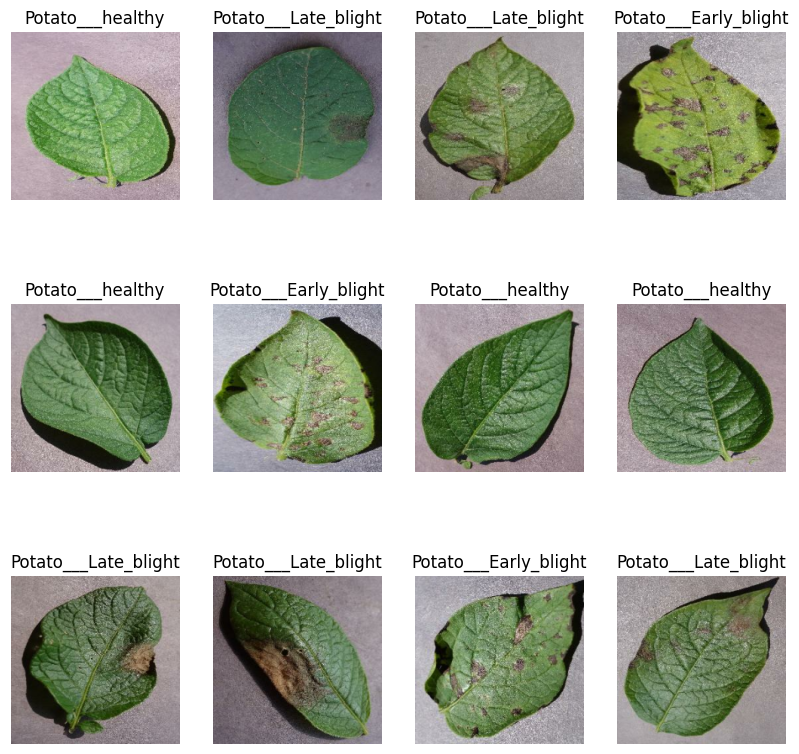

In [551]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

# Split the data set 

In [552]:
len(dataset)

68

In [553]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [554]:
train_ds = dataset.take(54)
len(train_ds)

54

In [555]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [556]:

val_size=0.1
len(dataset)*val_size

6.800000000000001

In [557]:

val_size=0.1
len(dataset)*val_size

6.800000000000001

In [558]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [559]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [560]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [561]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [562]:
len(train_ds)

54

In [563]:
len(val_ds)

6

In [564]:
len(test_ds)

8

In [565]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [566]:

# Create the resize and rescale model
resize_and_rescale = tf.keras.Sequential([
   layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define the input shape here
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [567]:
# Create the data augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [568]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [569]:


# Define constants
BATCH_SIZE = 32  # Example batch size, adjust as needed
IMAGE_SIZE = 224  # Example image size
CHANNELS = 3  # Number of color channels (e.g., RGB)
n_classes = 3  # Number of output classes

# Create the resize and rescale model with input shape
resize_and_rescale = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define the input shape here
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Define the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])




In [570]:
# Optionally, you can compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' depending on your labels
              metrics=['accuracy'])

# Print model summary to verify structure
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_32 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

In [571]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4532 - loss: 0.9418 - val_accuracy: 0.5469 - val_loss: 0.7969
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6332 - loss: 0.7313 - val_accuracy: 0.6562 - val_loss: 0.7521
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7608 - loss: 0.5326 - val_accuracy: 0.7396 - val_loss: 0.5596
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8040 - loss: 0.4610 - val_accuracy: 0.9115 - val_loss: 0.2581
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8550 - loss: 0.3584 - val_accuracy: 0.9323 - val_loss: 0.1876
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9089 - loss: 0.2416 - val_accuracy: 0.9479 - val_loss: 0.1363
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9286 - loss: 0.1765 - val_accuracy: 0.9062 - val_loss: 0.2523
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9392 - loss: 0.1578 - val_accuracy: 0.9740 - val_loss

In [572]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 259ms/step - accuracy: 0.9831 - loss: 0.0600


# Plotting the Accuracy and Loss Curves

In [573]:
history

In [574]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [575]:
type(history.history['loss'])

list

In [576]:
len(history.history['loss'])

10

In [577]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9006906151771545,
 0.6749958395957947,
 0.517615020275116,
 0.4109024405479431,
 0.3410654366016388]

In [578]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

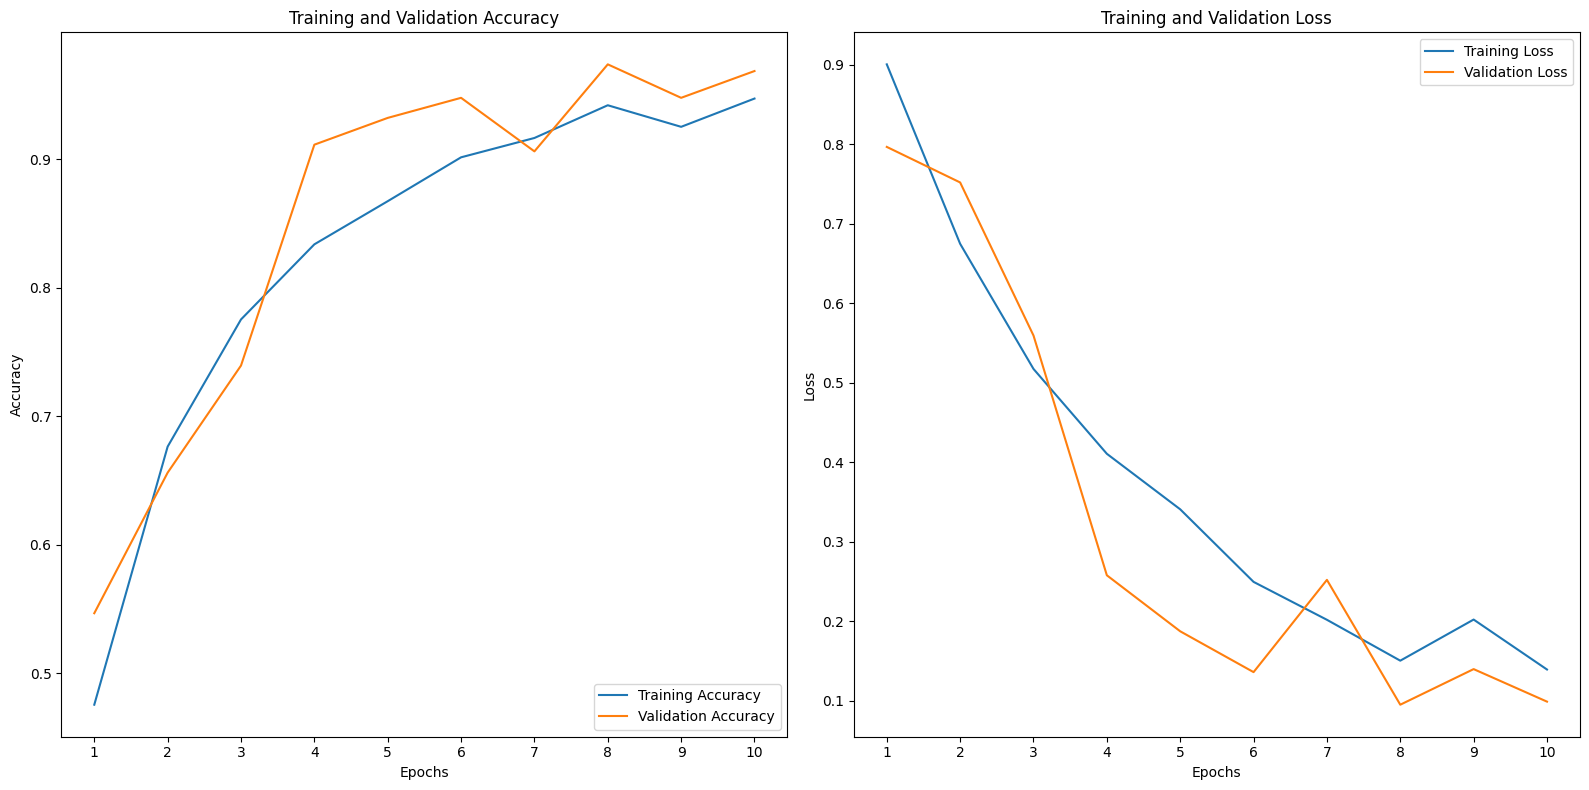

In [581]:
import matplotlib.pyplot as plt

# Number of epochs trained
num_epochs = len(acc)  # This should be 10

# Plot the metrics
plt.figure(figsize=(16, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), acc, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks for clarity
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks for clarity
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.tight_layout()
plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
predicted label: Potato___Early_blight


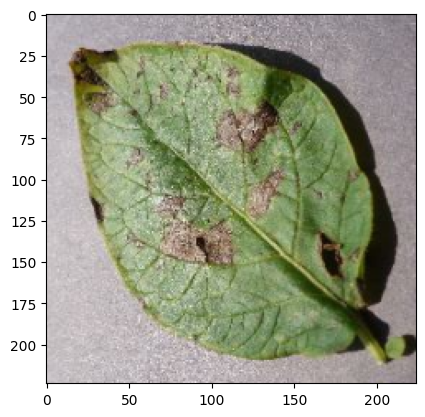

In [583]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [584]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


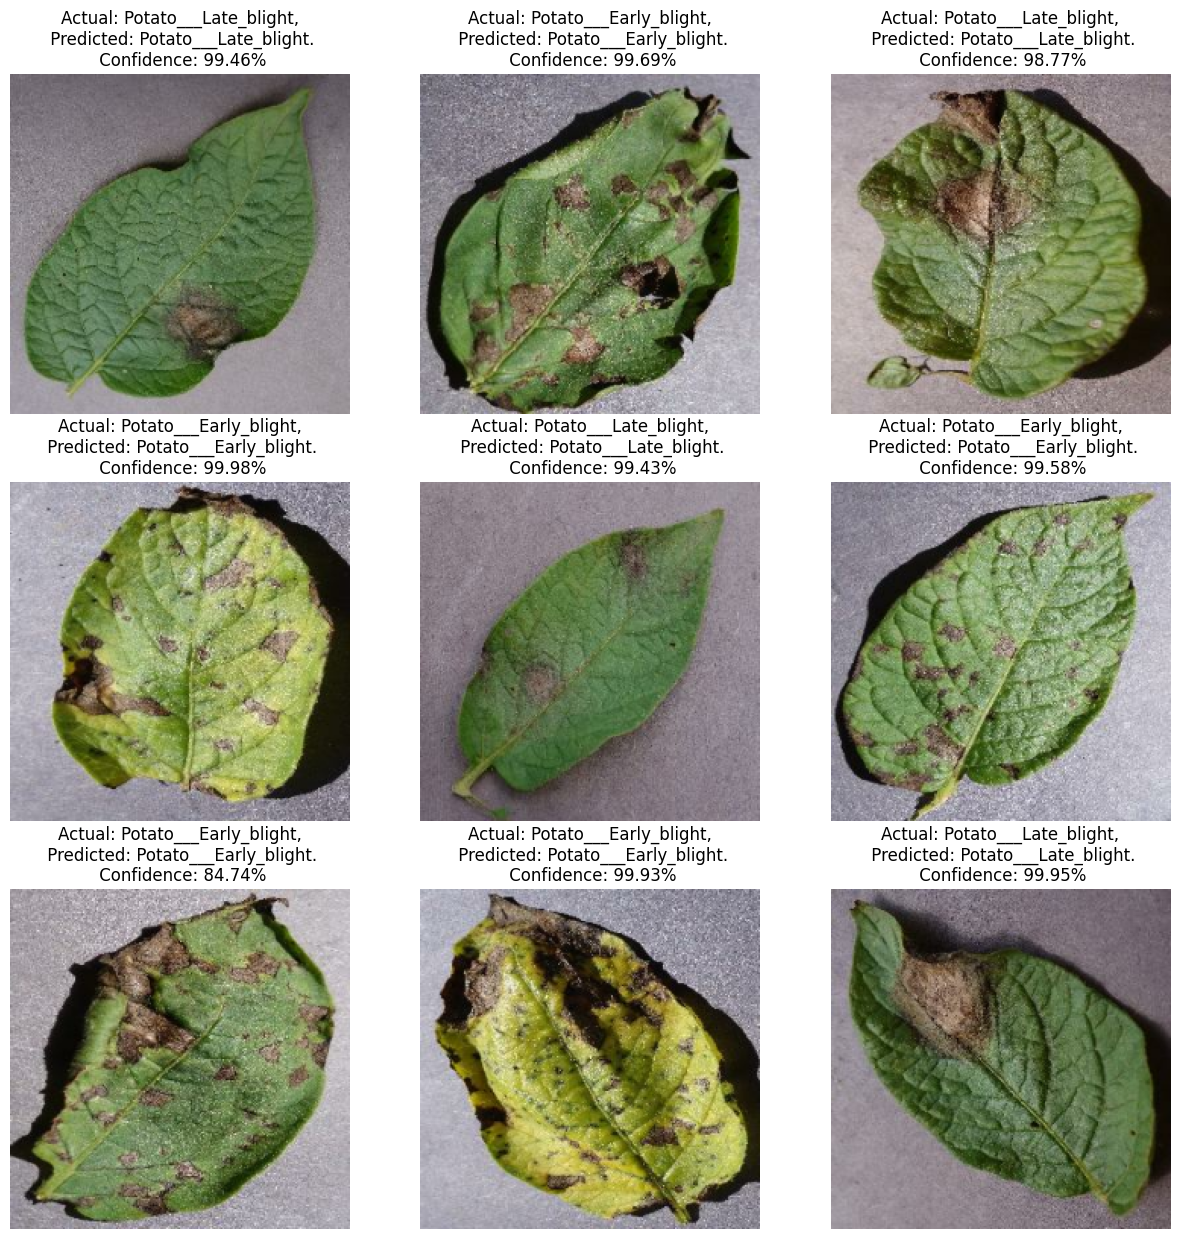

In [585]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [586]:
import os
# Define the model directory
model_dir = "../model"

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

try:
    model_version = max([int(i) for i in os.listdir(model_dir) if i.isdigit()] + [0]) + 1
except ValueError:
    model_version = 1  # Default to version 1 if no valid directories are found



In [588]:
model.save("./model/potatoes.h5")